Import librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing
import time
import random
import torch.nn.functional as F

In [2]:
language="italian"
language_w="../input/fasttext-aligned-word-vectors/wiki.it.align.vec"

In [3]:

text="testo"
review="cap_maj_master"
path_db="../input/ciao9cci/politica.xlsx"
n_top_class=24

In [4]:
#text="question_description"
#review="ministry"
#n_top_class=35
#path_db="/kaggle/input/rajyasabha/rajyasabha_q*.{}"
#import glob
#import pandas as pd
#extension = 'csv'
#all_filenames = [i for i in glob.glob(path_db.format(extension))]
#combine all files in the list
#df = pd.concat([pd.read_csv(f,encoding='latin1') for f in all_filenames ])



In [5]:
text="testo"
review="cap_maj_master"
path_db="../input/ciao9cci/politica.xlsx"
n_top_class=35
df = pd.read_excel(path_db, sheet_name="Foglio1")

In [6]:
top_class=df.groupby(review).count()[[text]]
top_class=top_class.sort_values(by=[text], ascending=False).head(n_top_class)
top_class=top_class.apply(list).reset_index()
top_class = [d for d in top_class[review]]
print(top_class)

df=df.loc[df[review].isin(top_class)]
print(f'Found {len(df)} texts.')
print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

df = df[df[text].str.split().str.len().gt(5)]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])
classes = [int(c) for c in df[review].values]
documents = [d for d in df[text]]

[12.0, 10.0, 20.0, 1.0, 3.0, 15.0, 5.0, 6.0, 7.0, 19.0, 4.0, 9.0, 2.0, 16.0, 21.0, 8.0, 13.0, 17.0, 14.0, 23.0, 18.0]
Found 5672 texts.
0 document(s) with no classification removed
0 document(s) with no text removed


Import dataset

21


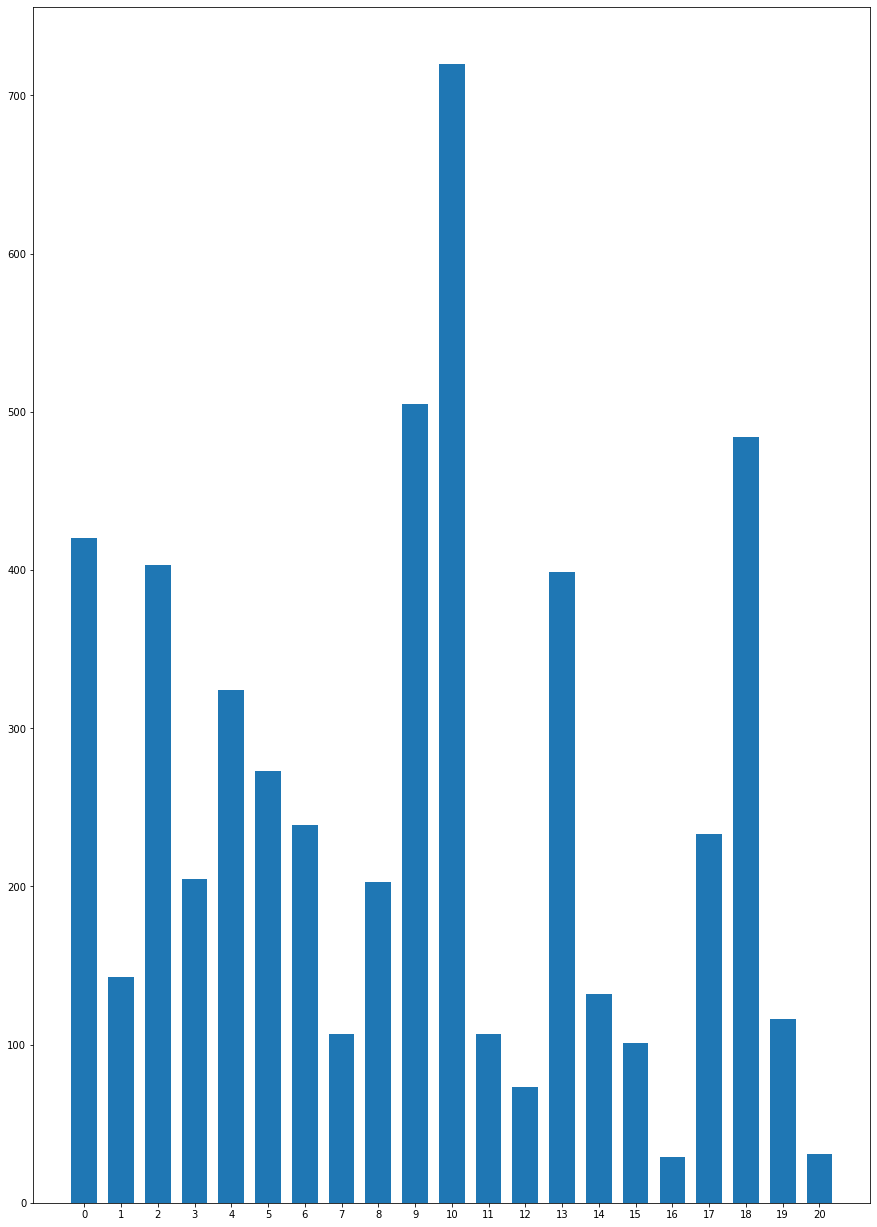

In [7]:
y = np.bincount(classes)
x = np.arange(len(y))
print(len(y))
fig, ax = plt.subplots(figsize=(15,22))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [8]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words(language))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [9]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

documents, vocab = split_words_documents(documents)

In [10]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print(quant)

1375
201.02611015818562
248.0


In [11]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [12]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

In [13]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(document+['']*(seq_length-len(document)))
    return np.array(documents),np.array(length)


In [14]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [15]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [16]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, language_w)
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:41, 20760.71it/s]


There are 135327 / 279895 pretrained vectors found.


In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE='cpu'
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [18]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

In [19]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [20]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
import numpy as np
import torch
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [22]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=False,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        packed = torch.nn.utils.rnn.pack_padded_sequence(h_embedding, text_length,batch_first=True, enforce_sorted=False)
        h_lstm, (h,c) = self.rnn(packed)
        h_lstm, output_lengths = nn.utils.rnn.pad_packed_sequence(h_lstm,batch_first=True)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        
        out=self.fc1(conc)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [23]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [24]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

In [25]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [26]:
batch_size = 128
output_dim = len(np.unique(classes))
print(output_dim)
dropout_pc = 0.5
n_epochs = 100
nfold=10
patience=5
hidden_dim=50
lr = 1e-3
num_layers=1
bidirectional=True

21


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.442779  | 301.190386 |   11.25   |   3.95   
Validation loss decreased (inf --> 301.190386).  Saving model ...
   2    |  363.929475  | 295.194584 |   11.25   |   3.87   
Validation loss decreased (301.190386 --> 295.194584).  Saving model ...
   3    |  353.614846  | 284.192191 |   11.25   |   3.96   
Validation loss decreased (295.194584 --> 284.192191).  Saving model ...
   4    |  339.510245  | 281.794821 |   14.38   |   3.89   
Validation loss decreased (284.192191 --> 281.794821).  Saving model ...
   5    |  316.186363  | 262.576080 |   21.72   |   3.84   
Validation loss decreased (281.794821 --> 262.576080).  Saving model ...
   6    |  288.288906  | 248.296751 |   23.75   |   3.83   
Validation loss decreased (262.576080 --> 248.296751).  Saving model ...


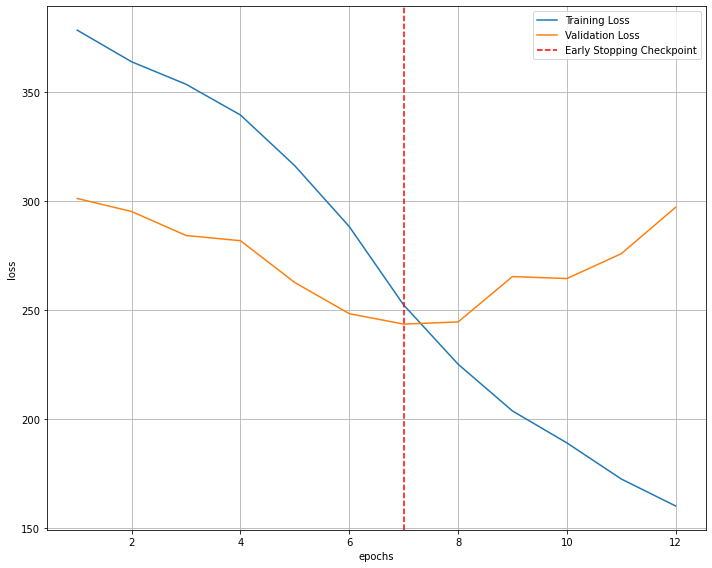

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.21      0.36      0.26        42
           1       0.00      0.00      0.00        15
           2       0.31      0.68      0.43        40
           3       0.36      0.24      0.29        21
           4       0.00      0.00      0.00        32
           5       0.23      0.37      0.29        27
           6       0.14      0.38      0.21        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        20
           9       0.40      0.74      0.52        50
          10       0.51      0.57      0.54        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

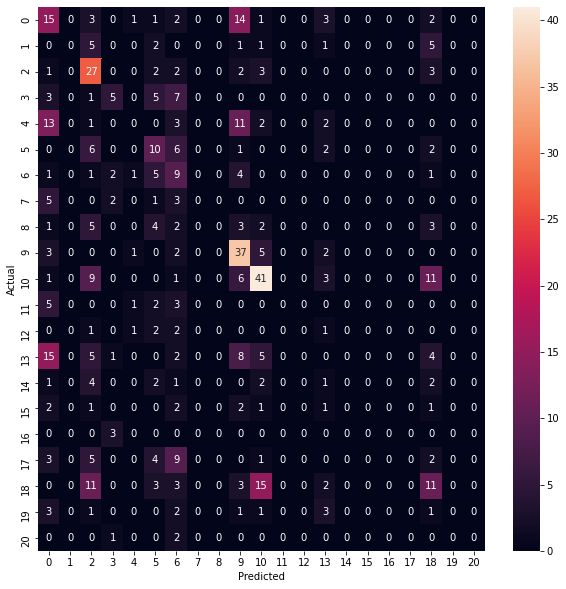


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  379.984464  | 301.182817 |   7.81    |   3.91   
Validation loss decreased (inf --> 301.182817).  Saving model ...
   2    |  365.255193  | 295.450899 |   11.25   |   4.29   
Validation loss decreased (301.182817 --> 295.450899).  Saving model ...
   3    |  355.789683  | 286.488346 |   11.25   |   3.85   
Validation loss decreased (295.450899 --> 286.488346).  Saving model ...
   4    |  337.064339  | 269.835556 |   14.84   |   3.86   
Validation loss decreased (286.488346 --> 269.835556).  Saving model ...
   5    |  312.147981  | 260.169593 |   18.28   |   3.97   
Validation loss decreased (269.835556 --> 260.169593).  Saving model ...
   6    |  290.625019  | 253.206311 |   23.12   |   3.85   
Validation loss decreased (260.169593 --> 253.206311).  Saving model ...

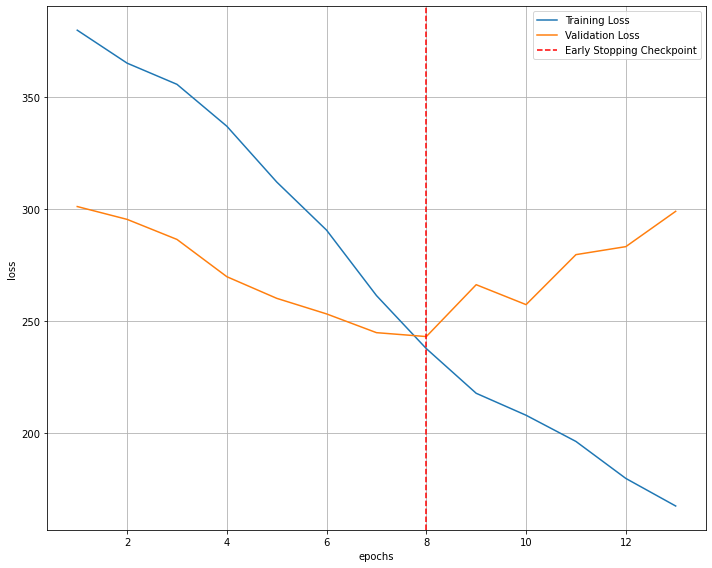

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.29      0.26      0.28        42
           1       0.00      0.00      0.00        15
           2       0.31      0.25      0.28        40
           3       0.32      0.60      0.42        20
           4       0.13      0.15      0.14        33
           5       0.25      0.57      0.35        28
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        20
           9       0.70      0.66      0.68        50
          10       0.63      0.75      0.68        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.10      0.10      0.10        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

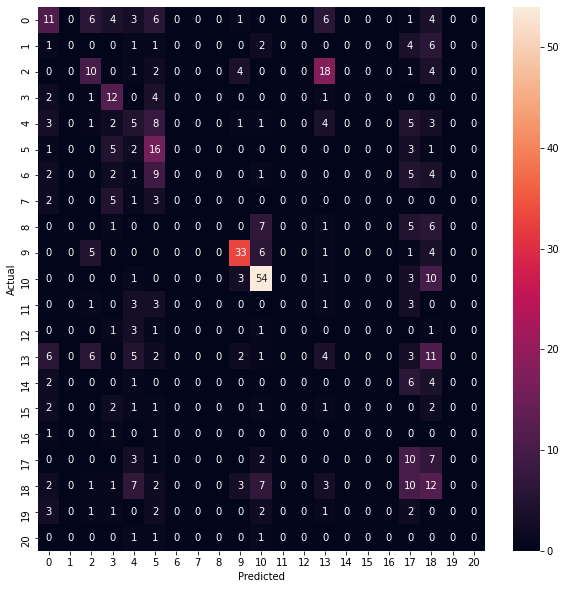


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  376.147271  | 299.869462 |   11.25   |   3.88   
Validation loss decreased (inf --> 299.869462).  Saving model ...
   2    |  362.826360  | 292.158622 |   11.25   |   3.84   
Validation loss decreased (299.869462 --> 292.158622).  Saving model ...
   3    |  352.080708  | 280.937481 |   11.25   |   3.98   
Validation loss decreased (292.158622 --> 280.937481).  Saving model ...
   4    |  332.880783  | 271.593277 |   18.59   |   3.85   
Validation loss decreased (280.937481 --> 271.593277).  Saving model ...
   5    |  312.906063  | 259.050742 |   20.16   |   4.01   
Validation loss decreased (271.593277 --> 259.050742).  Saving model ...
   6    |  282.429388  | 241.864766 |   32.25   |   3.85   
Validation loss decreased (259.050742 --> 241.864766).  Saving model ...

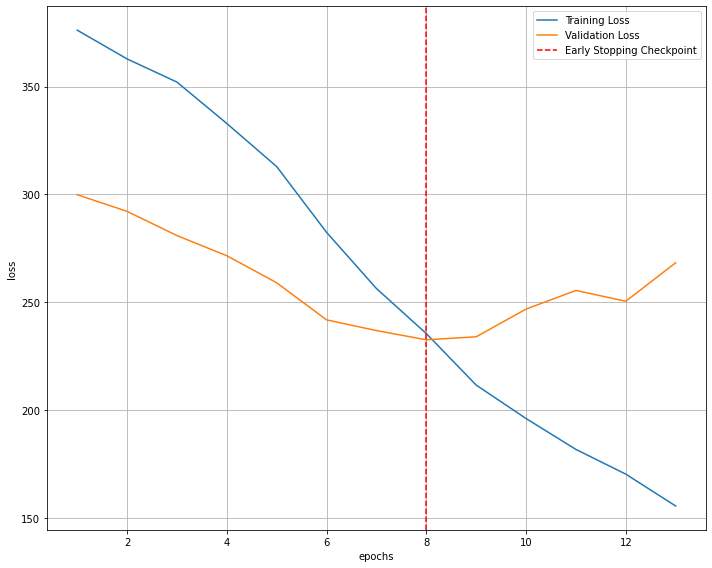

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.19      0.33      0.24        42
           1       0.00      0.00      0.00        14
           2       0.38      0.68      0.48        40
           3       0.17      0.50      0.25        20
           4       0.50      0.03      0.06        33
           5       0.64      0.50      0.56        28
           6       0.26      0.62      0.37        24
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        20
           9       0.69      0.74      0.71        50
          10       0.66      0.67      0.66        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.13      0.28      0.18        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

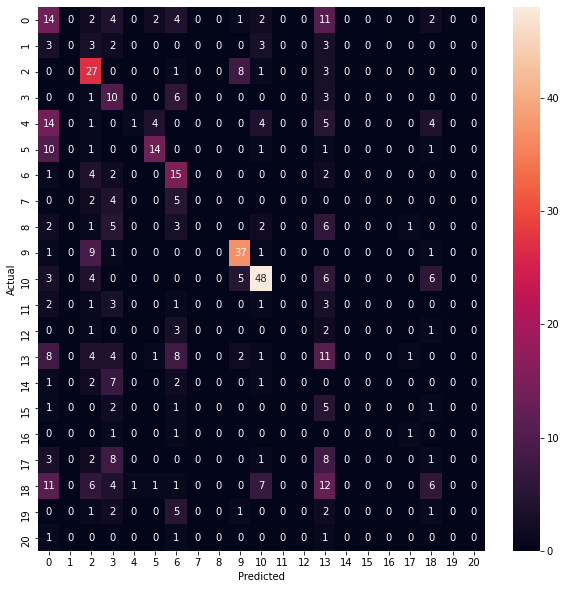


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  377.573677  | 298.225541 |   11.25   |   3.96   
Validation loss decreased (inf --> 298.225541).  Saving model ...
   2    |  363.020742  | 292.618593 |   11.25   |   3.86   
Validation loss decreased (298.225541 --> 292.618593).  Saving model ...
   3    |  352.487475  | 279.194626 |   11.25   |   3.88   
Validation loss decreased (292.618593 --> 279.194626).  Saving model ...
   4    |  331.275189  | 267.641867 |   21.88   |   3.94   
Validation loss decreased (279.194626 --> 267.641867).  Saving model ...
   5    |  310.125029  | 252.322288 |   22.50   |   3.87   
Validation loss decreased (267.641867 --> 252.322288).  Saving model ...
   6    |  282.629396  | 241.308342 |   25.47   |   3.84   
Validation loss decreased (252.322288 --> 241.308342).  Saving model ...

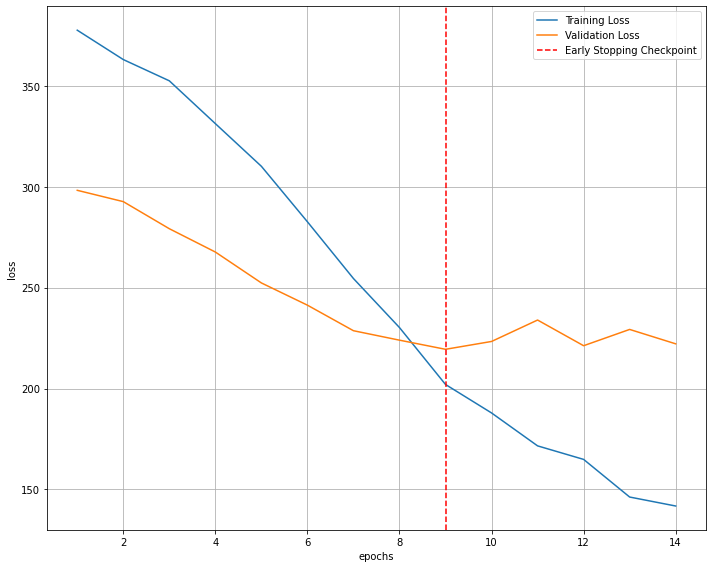

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.36      0.40      0.38        42
           1       0.00      0.00      0.00        14
           2       0.36      0.72      0.48        40
           3       0.38      0.65      0.48        20
           4       0.23      0.39      0.29        33
           5       0.00      0.00      0.00        28
           6       0.39      0.48      0.43        23
           7       0.00      0.00      0.00        11
           8       0.10      0.15      0.12        20
           9       0.70      0.76      0.73        50
          10       0.58      0.71      0.64        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.21      0.10      0.14        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

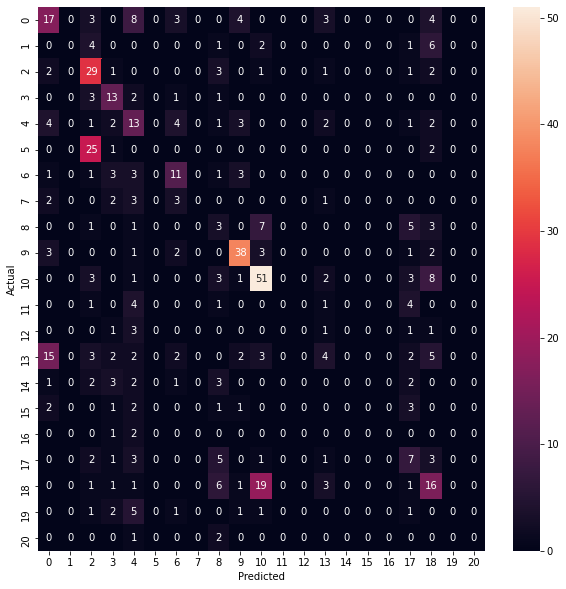


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.399934  | 298.353011 |   11.25   |   3.84   
Validation loss decreased (inf --> 298.353011).  Saving model ...
   2    |  362.734500  | 292.241441 |   11.25   |   3.86   
Validation loss decreased (298.353011 --> 292.241441).  Saving model ...
   3    |  350.456294  | 278.117504 |   15.94   |   3.95   
Validation loss decreased (292.241441 --> 278.117504).  Saving model ...
   4    |  327.339786  | 262.483681 |   19.69   |   3.93   
Validation loss decreased (278.117504 --> 262.483681).  Saving model ...
   5    |  302.896820  | 249.461276 |   24.69   |   3.88   
Validation loss decreased (262.483681 --> 249.461276).  Saving model ...
   6    |  278.573114  | 248.006872 |   25.62   |   3.86   
Validation loss decreased (249.461276 --> 248.006872).  Saving model ...

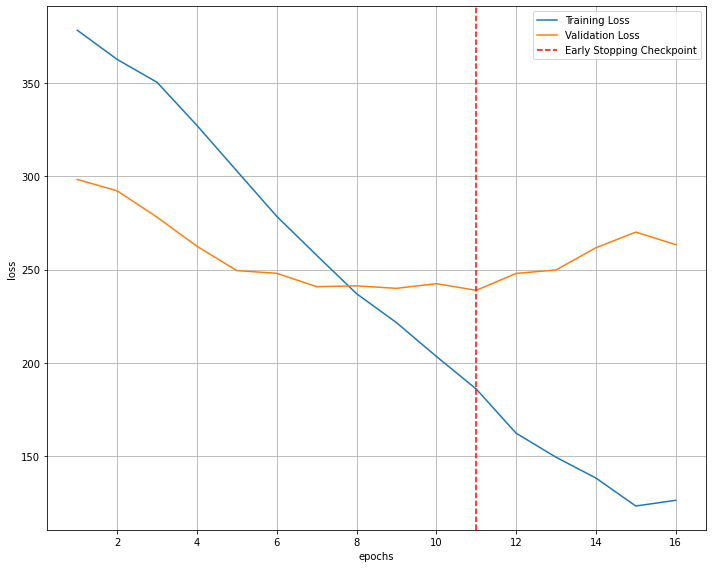

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.34      0.50      0.41        42
           1       0.00      0.00      0.00        14
           2       0.38      0.33      0.35        40
           3       0.30      0.45      0.36        20
           4       0.53      0.70      0.61        33
           5       0.57      0.78      0.66        27
           6       0.59      0.67      0.63        24
           7       0.33      0.18      0.24        11
           8       0.07      0.15      0.10        20
           9       0.74      0.78      0.76        51
          10       0.63      0.67      0.65        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.04      0.03      0.03        40
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

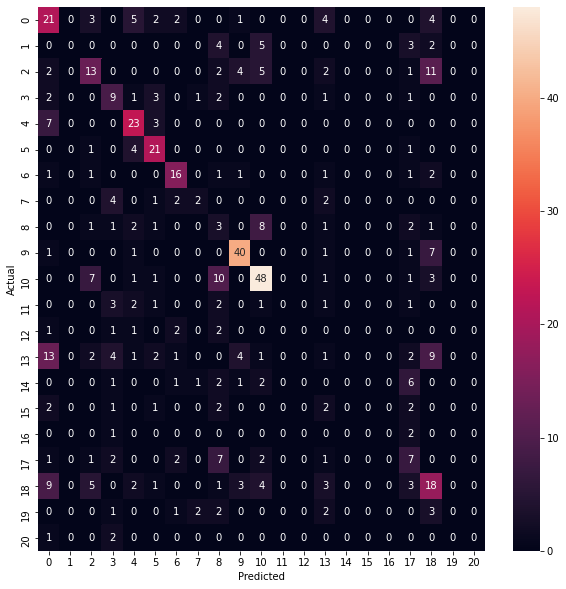


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  376.867894  | 299.009941 |   11.25   |   3.84   
Validation loss decreased (inf --> 299.009941).  Saving model ...
   2    |  363.284246  | 292.451373 |   11.25   |   3.93   
Validation loss decreased (299.009941 --> 292.451373).  Saving model ...
   3    |  352.868856  | 280.780936 |   11.25   |   3.90   
Validation loss decreased (292.451373 --> 280.780936).  Saving model ...
   4    |  338.383170  | 276.045648 |   11.41   |   3.85   
Validation loss decreased (280.780936 --> 276.045648).  Saving model ...
   5    |  329.284448  | 277.739135 |   14.53   |   3.86   
EarlyStopping counter: 1 out of 5
   6    |  316.206411  | 264.514860 |   17.50   |   3.89   
Validation loss decreased (276.045648 --> 264.514860).  Saving model ...
   7    |  293.456897  | 258.870747 | 

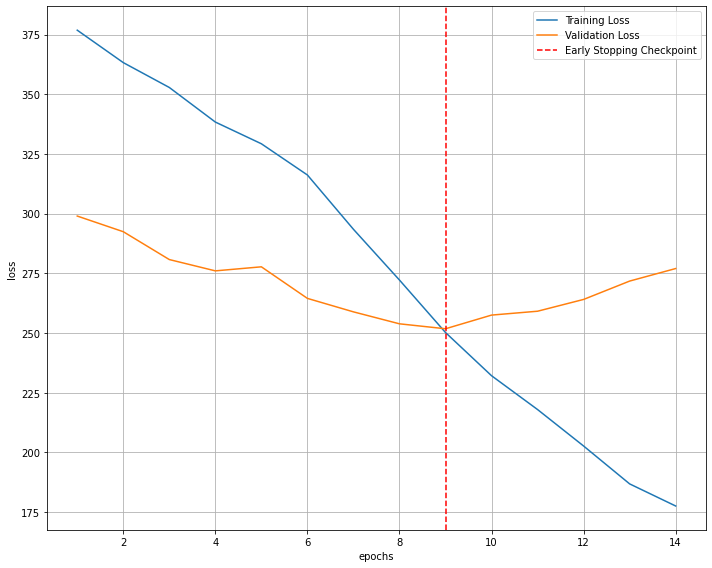

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.19      0.24      0.21        42
           1       0.00      0.00      0.00        14
           2       0.29      0.59      0.39        41
           3       0.19      0.30      0.24        20
           4       0.11      0.25      0.15        32
           5       0.19      0.44      0.27        27
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        11
           8       0.07      0.05      0.06        21
           9       0.64      0.75      0.69        51
          10       0.72      0.68      0.70        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.11      0.05      0.07        39
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        11
          16       0.00      0.00

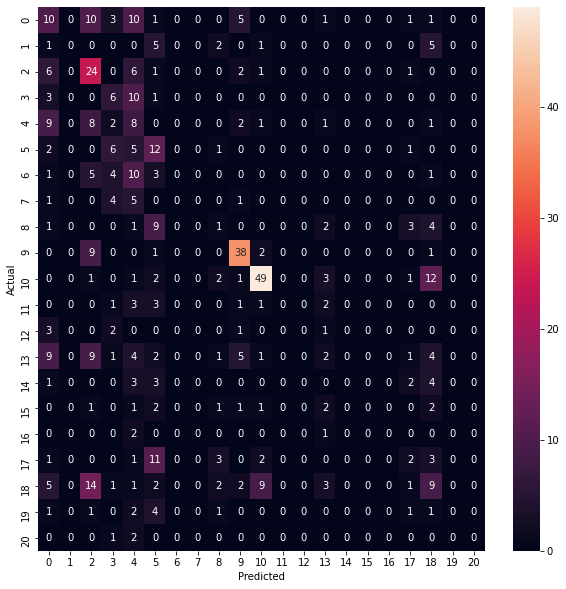


train: (4722, 248) len: 4722 train_y: 4722
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  382.651291  | 300.458506 |   11.25   |   3.87   
Validation loss decreased (inf --> 300.458506).  Saving model ...
   2    |  364.992588  | 291.236361 |   11.25   |   3.96   
Validation loss decreased (300.458506 --> 291.236361).  Saving model ...
   3    |  351.182480  | 277.754083 |   14.69   |   3.90   
Validation loss decreased (291.236361 --> 277.754083).  Saving model ...
   4    |  333.109441  | 261.172317 |   21.41   |   3.90   
Validation loss decreased (277.754083 --> 261.172317).  Saving model ...
   5    |  306.360813  | 240.461261 |   22.66   |   3.90   
Validation loss decreased (261.172317 --> 240.461261).  Saving model ...
   6    |  275.039928  | 223.726084 |   24.84   |   3.95   
Validation loss decreased (240.461261 --> 223.726084).  Saving model ...

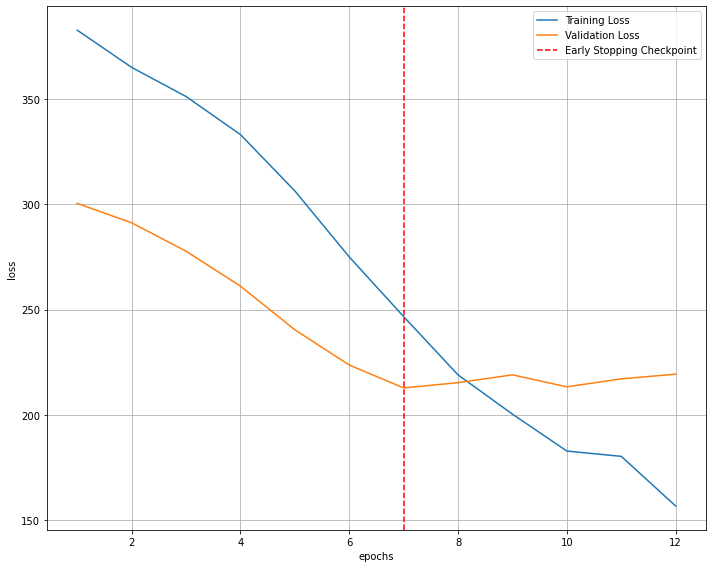

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.16      0.26      0.20        42
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        41
           3       0.33      0.10      0.15        21
           4       0.31      0.38      0.34        32
           5       0.18      0.74      0.29        27
           6       0.33      0.17      0.22        24
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        21
           9       0.42      0.84      0.56        51
          10       0.64      0.85      0.73        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.10      0.10      0.10        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

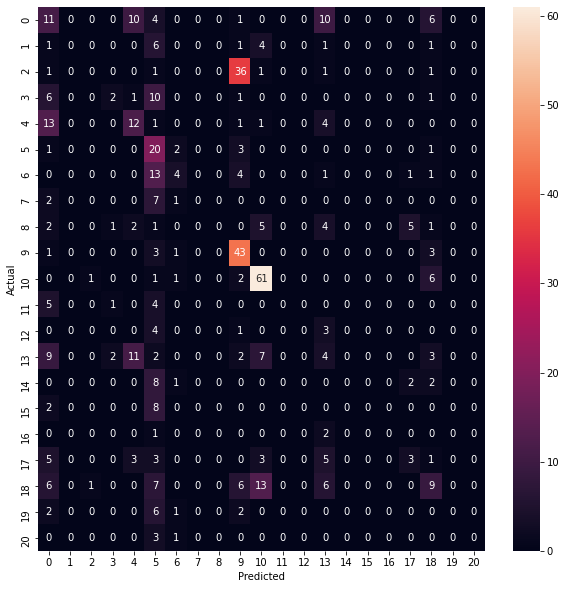


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.763497  | 294.580927 |   11.25   |   3.92   
Validation loss decreased (inf --> 294.580927).  Saving model ...
   2    |  363.968813  | 291.991867 |   11.25   |   3.88   
Validation loss decreased (294.580927 --> 291.991867).  Saving model ...
   3    |  353.651048  | 280.112400 |   11.56   |   3.95   
Validation loss decreased (291.991867 --> 280.112400).  Saving model ...
   4    |  333.934443  | 262.377602 |   20.94   |   3.88   
Validation loss decreased (280.112400 --> 262.377602).  Saving model ...
   5    |  304.019060  | 249.475294 |   25.00   |   4.13   
Validation loss decreased (262.377602 --> 249.475294).  Saving model ...
   6    |  273.882064  | 234.457231 |   27.81   |   3.90   
Validation loss decreased (249.475294 --> 234.457231).  Saving model ...

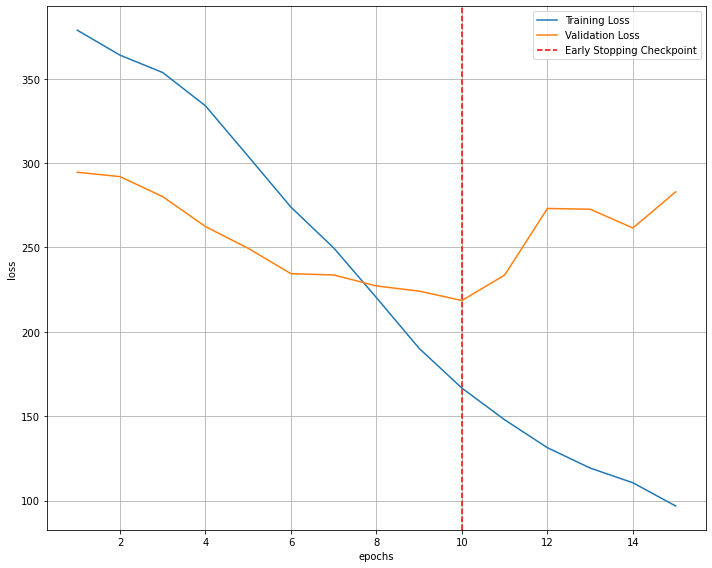

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.31      0.24      0.27        42
           1       0.00      0.00      0.00        14
           2       0.65      0.78      0.71        41
           3       0.33      0.76      0.46        21
           4       0.41      0.81      0.55        32
           5       0.82      0.85      0.84        27
           6       0.20      0.50      0.29        24
           7       0.00      0.00      0.00        10
           8       0.33      0.24      0.28        21
           9       0.65      0.63      0.64        51
          10       0.83      0.67      0.74        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.24      0.20      0.22        40
          14       0.43      0.23      0.30        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

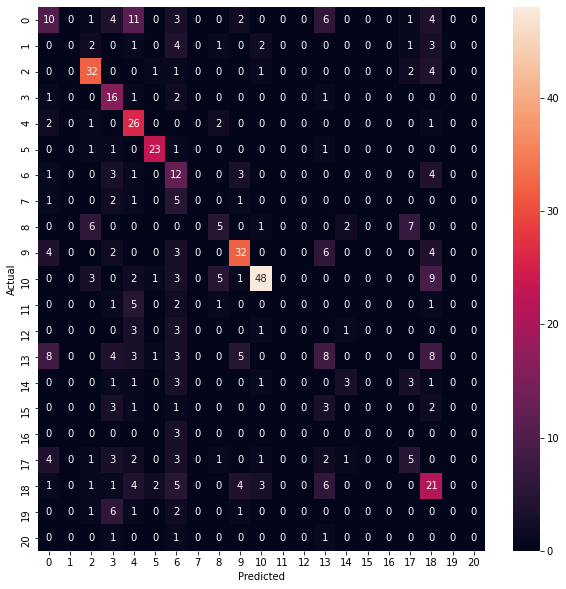


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  378.175776  | 296.659003 |   11.25   |   3.92   
Validation loss decreased (inf --> 296.659003).  Saving model ...
   2    |  364.346229  | 291.929406 |   11.25   |   3.88   
Validation loss decreased (296.659003 --> 291.929406).  Saving model ...
   3    |  355.817052  | 279.355273 |   11.25   |   3.95   
Validation loss decreased (291.929406 --> 279.355273).  Saving model ...
   4    |  338.530544  | 267.169129 |   13.12   |   3.87   
Validation loss decreased (279.355273 --> 267.169129).  Saving model ...
   5    |  318.942593  | 264.877402 |   13.91   |   3.94   
Validation loss decreased (267.169129 --> 264.877402).  Saving model ...
   6    |  301.194418  | 253.969950 |   17.97   |   4.04   
Validation loss decreased (264.877402 --> 253.969950).  Saving model ...

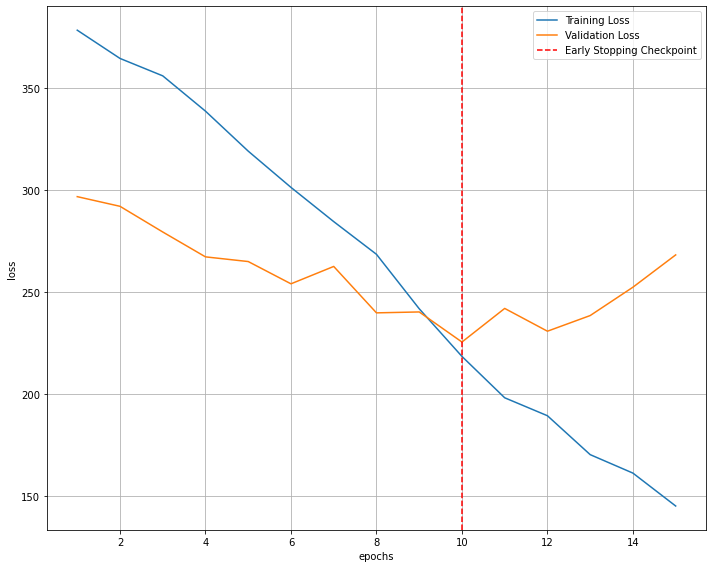

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.27      0.26      0.27        42
           1       0.00      0.00      0.00        14
           2       0.21      0.25      0.23        40
           3       0.00      0.00      0.00        21
           4       0.20      0.41      0.27        32
           5       0.24      0.81      0.37        27
           6       0.20      0.33      0.25        24
           7       0.00      0.00      0.00        10
           8       0.30      0.45      0.36        20
           9       0.76      0.76      0.76        51
          10       0.73      0.78      0.75        72
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         8
          13       0.23      0.12      0.16        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

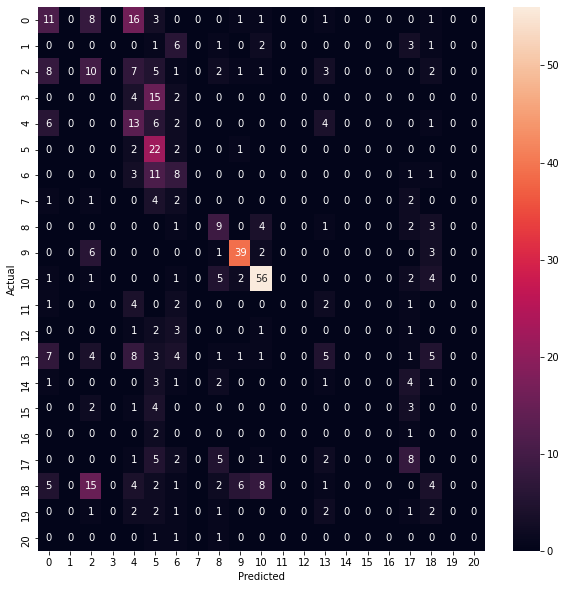


train: (4723, 248) len: 4723 train_y: 4723
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  380.223850  | 296.771237 |   11.25   |   3.88   
Validation loss decreased (inf --> 296.771237).  Saving model ...
   2    |  364.439845  | 292.172989 |   11.25   |   3.87   
Validation loss decreased (296.771237 --> 292.172989).  Saving model ...
   3    |  352.856956  | 285.774396 |   14.38   |   4.21   
Validation loss decreased (292.172989 --> 285.774396).  Saving model ...
   4    |  334.004575  | 268.314563 |   14.84   |   3.91   
Validation loss decreased (285.774396 --> 268.314563).  Saving model ...
   5    |  311.870994  | 264.532640 |   18.59   |   3.88   
Validation loss decreased (268.314563 --> 264.532640).  Saving model ...
   6    |  289.233827  | 244.762554 |   28.96   |   3.87   
Validation loss decreased (264.532640 --> 244.762554).  Saving model ...

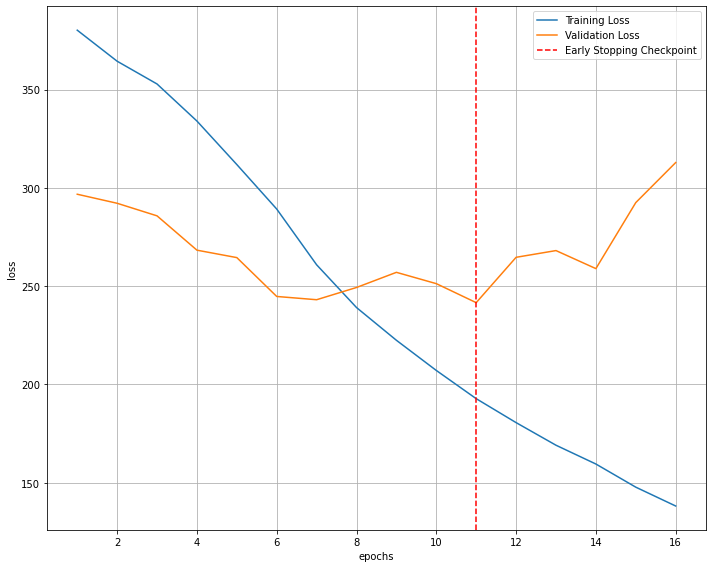

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.29      0.57      0.38        42
           1       0.00      0.00      0.00        15
           2       0.37      0.33      0.35        40
           3       0.33      0.76      0.46        21
           4       0.33      0.03      0.06        32
           5       0.71      0.37      0.49        27
           6       0.12      0.29      0.18        24
           7       0.00      0.00      0.00        11
           8       0.23      0.40      0.29        20
           9       0.79      0.62      0.70        50
          10       0.69      0.57      0.63        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.05      0.05      0.05        40
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

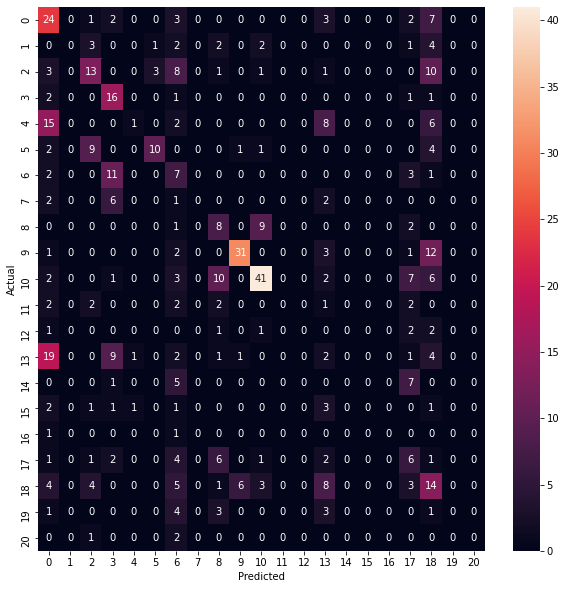

In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

accuracys = []
scores= []
metriche = np.zeros((nfold, 4,output_dim))

#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size, "train_y:",y[train_ids].size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    
    
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    model=model.double()
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr,weight_decay=0.01)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    
    target_names=np.unique(y[train_ids])
    accuracys.append(metrics.accuracy_score(y_true, y_pred))
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


In [28]:
print("Overall results of the cross-validation procedure")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")
print()
print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

Overall results of the cross-validation procedure

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 26.06 +/- 6.68  | 34.29 +/-11.08  | 28.94 +/- 7.04  |   42.00  
   1    | 0.00  +/- 0.00  | 0.00  +/- 0.00  | 0.00  +/- 0.00  |   14.30  
   2    | 32.72 +/-15.41  | 45.91 +/-24.85  | 36.98 +/-17.67  |   40.30  
   3    | 27.20 +/-11.14  | 43.57 +/-25.56  | 31.06 +/-14.87  |   20.50  
   4    | 27.49 +/-16.60  | 31.48 +/-26.52  | 24.48 +/-19.58  |   32.40  
   5    | 38.38 +/-26.16  | 54.42 +/-25.11  | 41.06 +/-22.24  |   27.30  
   6    | 22.50 +/-17.20  | 34.37 +/-22.30  | 25.69 +/-18.00  |   23.90  
   7    | 3.33  +/-10.00  | 1.82  +/- 5.45  | 2.35  +/- 7.06  |   10.70  
   8    | 11.05 +/-12.30  | 14.36 +/-16.13  | 12.03 +/-13.18  |   20.30  
   9    | 65.04 +/-12.92  | 72.85 +/- 6.77  | 67.53 +/- 7.77  |   50.50  
  10    | 66.22 +/- 8.24  | 69.03 +/- 8.19  | 67.18 +/- 6.05  |   72.00  
  11    | 0.00  +/- 0.00  | 0.00  +/- 0.00  | 0.00  +/- 0.00 